# Предсказание описаний

In [ ]:
!pip install --upgrade openai

В ходе данной работы я генерировала продолжения описаний фильмов, датасет всё тот же с фильмами с imdb :)

### Подгружаем датасет и немного обрабатываем

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
ds = pd.read_csv('movies_50000.csv')

In [ ]:
ds = ds[ds['user-votes'] != 'No data']
ds['user-votes'] = pd.to_numeric(ds['user-votes'], errors='coerce').fillna(0)

<ipython-input-3-68f6382cc861>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['user-votes'] = pd.to_numeric(ds['user-votes'], errors='coerce').fillna(0)


In [ ]:
ds = ds.drop(columns='Unnamed: 0')

In [ ]:
ds = ds.drop_duplicates().sort_values(by=['user-votes'], axis=0, ascending=False)

Минимальный размер описания 10 токенов, максимальный 436

In [ ]:
min(ds.descriptions.str.len())

10

In [ ]:
ds[:3000]

,title,genre,year,certificate,runtime,user-votes,imdb-scores,metacritic-scores,descriptions,stars
120,The Shawshank Redemption,Drama,1994.0,R,142,2818211,9.3,82,"Over the course of several years, two convicts...",Director:\nFrank Darabont\n| \n Stars:\...
179,The Dark Knight,"Action,Crime,Drama",2008.0,PG-13,152,2799705,9.0,84,When the menace known as the Joker wreaks havo...,Director:\nChristopher Nolan\n| \n Star...
162,Fight Club,Drama,1999.0,R,139,2253243,8.8,67,An insomniac office worker and a devil-may-car...,Director:\nDavid Fincher\n| \n Stars:\n...
15,Game of Thrones,"Action,Adventure,Drama",20112019.0,TV-MA,"4,189",2221168,9.2,No data,Nine noble families fight for control over the...,"\n Stars:\nEmilia Clarke, \nPet..."
341,Forrest Gump,"Drama,Romance",1994.0,PG-13,142,2194831,8.8,82,The history of the United States from the 1950...,Director:\nRobert Zemeckis\n| \n Stars:...
...,...,...,...,...,...,...,...,...,...,...
356,Doctor Who,"Adventure,Drama,Family",19631989.0,TV-PG,45,38616,8.4,No data,The adventures in time and space of the Doctor...,"\n Stars:\nWilliam Hartnell, \n..."
8056,Heist,"Action,Crime,Drama",2001.0,R,109,38604,6.5,66,A career jewel thief finds himself at tense od...,Director:\nDavid Mamet\n| \n Stars:\nGe...
6973,Undisputed 2: Last Man Standing,"Action,Crime,Drama",2006.0,R,98,38600,7.0,No data,"Sequel to the 2002 film. This time, Heavyweigh...",Director:\nIsaac Florentine\n| \n Stars...
2881,Freaks,"Drama,Mystery,Sci-Fi",2018.0,R,105,38591,6.7,63,"A bold girl discovers a bizarre, threatening, ...","Directors:\nZach Lipovsky, \nAdam B. Stein..."


Скрипт под апи от чатгпт. Понятно, что модельку можно поменять, взяла гпт 3.5, т.к. самая дешёвая, гпт 4 не пробовала, стоит намного дороже. Моё обучение на датасете в 5000 записей, кажется, обошлось бы в 6500

Получается, контент для ролей：
system - входная роль для чатгпт
user - изначальный промпт
assistant - используется для хранения предыдущих знаний, в диалогах предыдущий ответ добавляется сюда, также можно использовать для few-shot learning and Chain of thoughts

In [ ]:
from openai import OpenAI

In [ ]:
api_kek = "kek"

In [ ]:
client = OpenAI(api_key=api_kek)

Я запускала пару раз, но проблема в том, что лимит в 5 баксов я перевалила, так что всё обработать нереально мне было без зарубежной карты. Тут пример, как бы я писала промпт и так далее: 

Пример, как это вообще может быть:

In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    # {"role": "user", "content": "Who won the world series in 2020?"},
    # {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    # {"role": "user", "content": "Where was it played?"}
  ]
)


Пример запроса:

In [ ]:

  messages += [{'role': "user", "content": please give me a rich description of a f{'title'} with a yer {'year'}, here is a brief description {'description'},
                please write at least 500 characters, here is a cast of this film {'stars'}}]
  ds += completion.choices[0].message.content

In [ ]:
completion.choices[0].message.content

'The World Series in 2020 was played at Globe Life Field, a baseball stadium in Arlington, Texas.'

In [ ]:
# На выходе получаем обычную табличку в одну колонку, как например
df = ds[["descriptions"]]

In [ ]:
df

### Эмбеддинги и моделька 

Эмбединг нашего текста

In [ ]:
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Делим датасет на тренировочный и валидационный
n = int(0.9 * len(df))
train_ds = df[:n]
val_ds = df[n:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_ds))
val_ds = tf.data.Dataset.from_tensor_slices((val_ds))

In [ ]:
max_features = 5000
BATCH_SIZE = 32

Можно сделать sub-work tokenizer из tensorflow

In [ ]:
# Создаём словарик с помощью TextVectorization будет словарь из н-грамм слов (я знаю, что н-граммы не активно пользуют, но это наиболее понятно)
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
)
vectorize_layer.adapt(train_ds, batch_size=None)

In [ ]:
# Полученный словарик
vocabulary = vectorize_layer.get_vocabulary()

In [ ]:
len(vocabulary)

In [ ]:
MAX_TOKENS = 128
BUFFER_SIZE = 1000

In [ ]:
def prepare_batch(data):
    x = vectorize_layer(data)
    x = x[:, :(MAX_TOKENS)]
    X_train = x[:, :-1]
    y_train = x[:, 1:]
    return (X_train, y_train)

In [ ]:
def make_batches(ds):
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [ ]:
# Тренировочные и валидационные бачи
train_batches = make_batches(train_ds)
val_batches = make_batches(val_ds)

In [ ]:
for x_batch, y_batch in train_batches.take(1):
    break

Началась моделька

In [ ]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output, attn_scores = self.mha(
            query=x, value=x, key=x, return_attention_scores=True, use_causal_mask=True
        )
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        self.last_attn_scores = self.causal_self_attention.last_attn_scores
        x = self.ffn(x)
        return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]

        self.last_attn_scores = None

    def call(self, x):
        x = self.pos_embedding(x)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return x

In [ ]:
sample_decoder = Decoder(
    num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000
)

output = sample_decoder(x=x_batch)

In [ ]:
x_batch.shape
output.shape

(32, 38)
(32, 38, 512)


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1
    ):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs):

        x = inputs

        x = self.decoder(x)

        logits = self.final_layer(x)  

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vectorize_layer.vocabulary_size(),
    dropout_rate=dropout_rate)

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
history = transformer.fit(train_batches, epochs=10, validation_data=val_batches)

Epoch 1/10
277/277 [==============================] - 353s 1s/step - loss: 8.0738 - masked_accuracy: 0.0809 - val_loss: 7.4288 - val_masked_accuracy: 0.1270
Epoch 2/10
277/277 [==============================] - 326s 1s/step - loss: 6.8120 - masked_accuracy: 0.1060 - val_loss: 6.0485 - val_masked_accuracy: 0.1277
Epoch 3/10
277/277 [==============================] - 315s 1s/step - loss: 5.9945 - masked_accuracy: 0.1313 - val_loss: 5.6375 - val_masked_accuracy: 0.1661
Epoch 4/10
277/277 [==============================] - 313s 1s/step - loss: 5.6634 - masked_accuracy: 0.1627 - val_loss: 5.3832 - val_masked_accuracy: 0.1785
Epoch 5/10
277/277 [==============================] - 309s 1s/step - loss: 5.4135 - masked_accuracy: 0.1788 - val_loss: 5.1800 - val_masked_accuracy: 0.1907
Epoch 6/10
277/277 [==============================] - 326s 1s/step - loss: 5.2054 - masked_accuracy: 0.1916 - val_loss: 5.0224 - val_masked_accuracy: 0.2069
Epoch 7/10
277/277 [==============================] - 306s

В описании к лабе писалось про 30+ эпох, но в данном случае показалось чрезмерным, хотя всё ещё лосс падает

<Axes: >

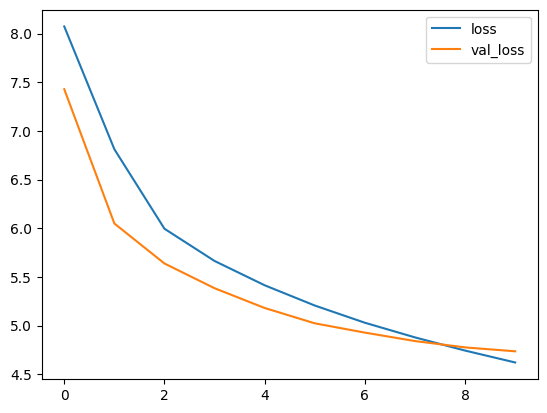

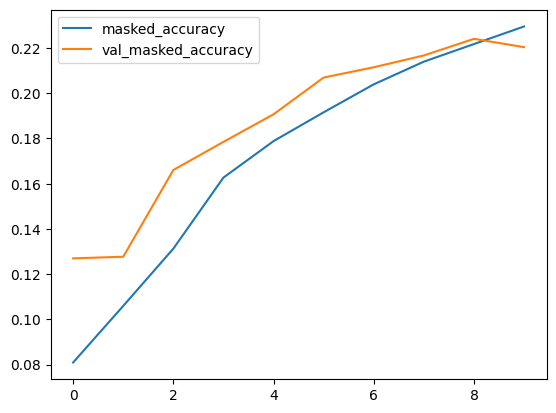

In [ ]:
metrics_df = pd.DataFrame(history.history)
metrics_df[["loss", "val_loss"]].plot()
metrics_df[["masked_accuracy", "val_masked_accuracy"]].plot()

In [ ]:
sentence = "Once upon a time in a galaxy far far away"
x = vectorize_layer(sentence)
x = tf.expand_dims(x, axis=0)
prediction = transformer(x)
predicted_id = tf.argmax(prediction, axis=-1)
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=vocabulary, mask_token="", oov_token="[UNK]", invert=True
)

In [ ]:
id_to_word(predicted_id)

<tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'years', b'a', b'[UNK]', b'of', b'the', b'[UNK]', b'and',
        b'[UNK]', b'for', b'from']], dtype=object)>

In [ ]:
class Generator(tf.Module):
    def __init__(
        self,
        tokenizer,
        vocabulary,
        transformer,
        max_new_tokens,
        temperature=0.0,
    ):
        self.tokenizer = tokenizer
        self.transformer = transformer
        self.vocabulary = vocabulary
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature

    def __call__(self, sentence, max_length=MAX_TOKENS):
        sentence = self.tokenizer(sentence)
        sentence = tf.expand_dims(sentence, axis=0)
        encoder_input = sentence
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        print(f"Generating {self.max_new_tokens} tokens")
        for i in tf.range(self.max_new_tokens):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer(encoder_input, training=False)

            predictions = predictions[:, -1:, :]
            if self.temperature == 0.0:
                predicted_id = tf.argmax(predictions, axis=-1)
            else:
                predictions = predictions / self.temperature
                predicted_id = tf.random.categorical(predictions[0], num_samples=1)


            output_array = output_array.write(i + 1, predicted_id[0])
            encoder_input = tf.experimental.numpy.append(encoder_input, predicted_id[0])
            encoder_input = tf.expand_dims(encoder_input, axis=0)

        output = tf.transpose(output_array.stack())
        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vocabulary, mask_token="", oov_token="[UNK]", invert=True
        )

        print(f"Using temperature of {self.temperature}")
        text = id_to_word(output)
        tokens = output

        self.transformer(output[:, :-1], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

Температуру можно покрутить. Чем "холоднее", тем мы "креативнее"

In [ ]:
max_new_tokens = 20
temperature = 0.85
generator = Generator(
    vectorize_layer, vocabulary, transformer, max_new_tokens, temperature,
)
def print_generation(sentence, generated_text):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Generation":15s}: {generated_text}')
sentence = "Once upon a time in a galaxy far far away"
generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)

Generating 20 tokens
Using temperature of 0.9
Input:         : Once upon a time in a galaxy far far away
Generation     : [[b'' b'with' b'her' b'friends' b'almost' b'may' b'be' b'she' b'uses'
  b'[UNK]' b'to' b'avoid' b'run' b'by' b'longs' b'for' b'her' b'own'
  b'feelings' b'for' b'her']]
